In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns

In [2]:
def phi_j_t(X, j, t, t_val, tau_val):
    
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[j, :tt + 1])
    return phi

def phi_t(X, t, t_val, tau_val):
    
    cumulative_time_array = np.arange(0, t + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), data[:, :t + 1].transpose())
    return phi


def eta_i_t(X, i, t, t_val, tau_val, eta_0):
    
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[i, :tt + 1])
    return -eta_0 * phi


def rho_i_t(u, i, t, v, delta_u):
    
    return rho_0 * np.exp(u[i, t] - v / delta_u)



In [4]:
num_neurons = 15
num_timebins = 99
num_iter = 40

tau = 0.01
eta_0 = 0.1
tau_adapt = 0.01
rho_0 = 1
v = 0
delta_u = 1
mu_M = 0.000001
mu_Q = 0.00001
tau_G = 0.01
tau_baseline = 0.1

## Generate synthetic data
data = np.random.binomial(n = 1, p = 0.1, size = [num_neurons, num_timebins])
true_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons])
learned_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons])

## Initialize arrays
potentials = np.zeros((num_neurons, num_timebins))



In [5]:
## Generate synthetic spike counts


# ## From weight matrix
# for tt in range(num_timebins):
#     for ii in range(num_neurons):
        
#         potential_list = []
#         for jj in range(num_neurons):
#             curr_cumulative_time_array = np.arange(0, tt + 1) # should this be tt + 1?
#             first_term = true_weights[ii, jj] * np.dot(np.exp(-(tt - curr_cumulative_time_array) / tau), data[jj, :tt + 1])
#             second_term = -eta_0 * np.dot(np.exp(-(tt - curr_cumulative_time_array) / tau_adapt), data[jj, :tt + 1])
#             curr_pot = first_term + second_term
#             potential_list.append(curr_pot)

#         potentials[ii, tt] = np.sum(potential_list)
        
# data = np.random.poisson(lam=np.exp(potentials - v / delta_u))



## staircase

neuron_block_size = np.floor(num_neurons / 3)
data = np.zeros((num_neurons, num_timebins))
curr_neuron_block = 0

curr_stair_idx = 0
while curr_stair_idx <= num_timebins:
    curr_stair_length = np.int(np.random.uniform(low=10, high = 30))
    data[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1)* neuron_block_size), curr_stair_idx:curr_stair_idx + curr_stair_length] = 1
    if curr_neuron_block < 2:
        curr_neuron_block += 1
    else:
        curr_neuron_block = 0
    curr_stair_idx += curr_stair_length
    
# randomly flip some bits
bit_flip_mask = np.random.binomial(n = 1, p = 0.05, size=(num_neurons, num_timebins))
data[bit_flip_mask.astype(bool)] = np.abs(data[bit_flip_mask.astype(bool)] - 1)

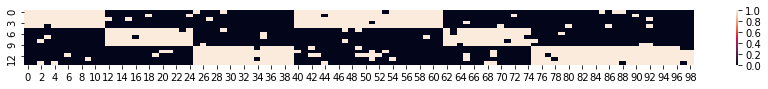

In [6]:
fig, ax = plt.subplots(figsize=(15,1))  
sns.heatmap(data)

In [7]:
mse_trace = []
# curr_mse = np.mean((true_weights - learned_weights)**2)
# mse_trace.append(curr_mse)
# print curr_mse
for _ in range(num_iter):
    
    ## Update membrane potential
    for ii in range(num_neurons):
        
        # loop over time bins
        for tt in range(num_timebins):
            
            tt_val = tt / 1000.
            
            ## loop over neurons
            cumulative_time_array = np.arange(0, tt + 1) / 1000.
            phi_unscaled = phi_t(X=data, t=tt, t_val=tt_val, tau_val=tau)
            phi = np.dot(learned_weights[ii, :], phi_unscaled)
            
            eta = eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)
            potentials[ii, tt] = phi + eta
            
    
    ## Update weights
    for ii in range(num_neurons):
        for jj in range(num_neurons):
        
            ## loop over time bins
            timebin_summands = []
            for tt in range(num_timebins):
                
                tt_val = tt / 1000.
                
                phi = phi_t(X=data, t=tt, t_val=tt_val, tau_val=tau)
                phi_squared = phi**2
                
#                 g_prime_over_g = phi_j_t(X=data, tau_val=tau, t=tt, j=jj, t_val=tt_val) / rho_i_t(u=potentials, v=v, t=tt, i=ii, delta_u=delta_u)
                
                x_minus_rho = data[ii, tt] - rho_i_t(u=potentials, v=v, t=tt, i=ii, delta_u=delta_u)
                
#                 phi = phi_j_t(X=data, tau_val=tau_adapt, t=tt, j=jj, t_val=tt_val)
                                
#                 summand = g_prime_over_g * x_minus_rho * phi
                summand = phi_squared * x_minus_rho
                timebin_summands.append(summand)
                
            final_weight = mu_M * np.sum(timebin_summands)
            learned_weights[ii, jj] = final_weight
            
    curr_mse = np.mean((data - np.exp(potentials))**2)
    mse_trace.append(curr_mse)
    print curr_mse

7.649715679487313
0.4264355379163972
0.7309560606859196
0.3628468373228265
0.5265534283989539
0.34912270588484984
0.4528967147227505
0.3490868796313295
0.41835233158576207
0.3527882126605744
0.3999512593818647
0.3569357053217478
0.3893539421203515
0.3605062778839777
0.38292027492625264
0.3632968631101582
0.37886601142947596
0.36538055577093637
0.3762410071488052
0.36690000770550407
0.3745066952056135
0.36799411104991836
0.37334291337143044
0.3687767989305604
0.372552298096196
0.3693350225357333
0.3720097624361838
0.3697327935633085
0.37163431024002086
0.37001633794273314
0.37137260222610285
0.37021869183310585
0.37118903035204803
0.37036333813534855
0.3710595535212134
0.37046692922241753
0.3709677837175716
0.37054126743913496
0.37090245651448606
0.37059472297237406


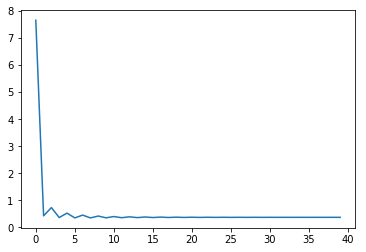

In [8]:
plt.plot(mse_trace)

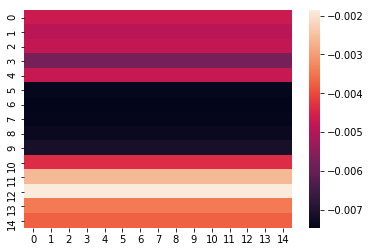

In [9]:
sns.heatmap(learned_weights)

In [10]:
## Generate data from learned weights

simulated_potentials = np.zeros((num_neurons, num_timebins))
## From weight matrix
for _ in range(num_iter):
    
    ## Update membrane potential
    for ii in range(num_neurons):
        
        # loop over time bins
        for tt in range(num_timebins):
            
            tt_val = tt / 1000.
            
            ## loop over neurons
            potential_list = []
            for jj in range(num_neurons):
                
                curr_weight = learned_weights[ii, jj] * phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
                potential_list.append(curr_weight)
                
            simulated_potentials[ii, tt] = np.sum(potential_list) + eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)

In [11]:
poisson_rates = np.zeros((num_neurons, num_timebins))
for ii in range(num_neurons):
    for tt in range(num_timebins):
        poisson_rates[ii, tt] = rho_i_t(delta_u=delta_u, i=ii, t=tt, u=simulated_potentials, v=v)


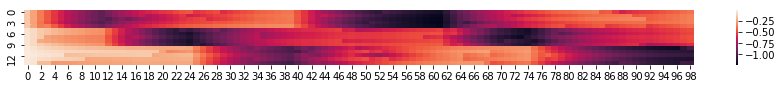

In [12]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(simulated_potentials)

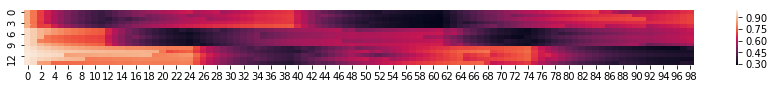

In [13]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(poisson_rates)

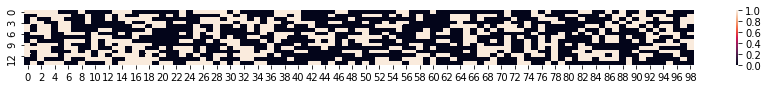

In [14]:
simulated_spikes = np.random.poisson(lam=poisson_rates)
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap((simulated_spikes >= 1).astype(int))
plt.show()

In [15]:
np.mean(simulated_spikes)

0.5461279461279461

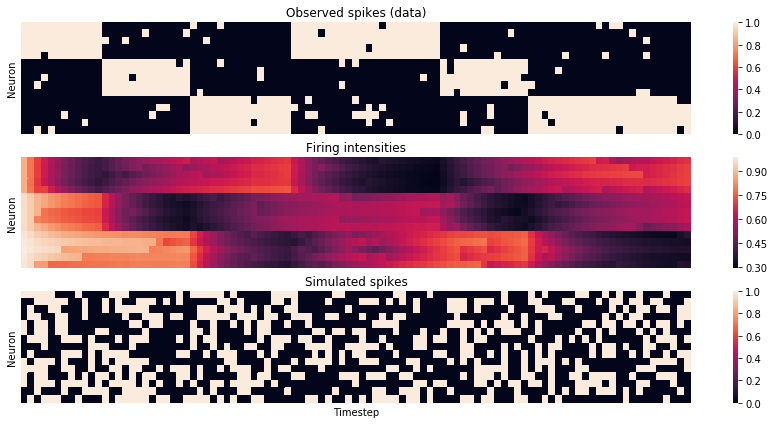

In [16]:
fig, ax = plt.subplots(figsize=(15,7))
plt.subplot(3, 1, 1)
sns.heatmap(data, xticklabels=False, yticklabels=False)
plt.title("Observed spikes (data)")
plt.ylabel("Neuron")
plt.subplot(3, 1, 2)
sns.heatmap(poisson_rates, xticklabels=False, yticklabels=False)
plt.title("Firing intensities")
plt.ylabel("Neuron")
plt.subplot(3, 1, 3)
sns.heatmap((simulated_spikes >= 1).astype(int), xticklabels=False, yticklabels=False)
plt.title("Simulated spikes")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.savefig("/Users/andrewjones/Desktop/firing_rates.png")
plt.show()